# LangGraph: Interrupts and Time Travel

This notebook demonstrates how to pause workflow execution with interrupts and travel back to previous states.

In [ ]:
import uuid

from typing import TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain.chat_models import init_chat_model

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
class State(TypedDict):
    topic: Optional[str]
    joke: Optional[str]

In [3]:
# model = ChatOllama(model='qwen2.5')
model = init_chat_model(
    "gpt-5-mini",
    temperature=0.5
)

In [4]:
def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    
    msg = model.invoke("Give me a random topic of one word. I will create a joke about this topic. Do not give any explanation or extra details.")
    return {"topic": msg.content}

## Using Interrupts

The `interrupt()` function pauses execution and returns control to the caller. When resumed with `Command(resume=<value>)`, the interrupt returns that value.

In [5]:
from langgraph.types import interrupt

def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    # ask user if we should proceed
    approval = interrupt(f"Do you want to hear a joke about {state['topic']}? (Y/N)")

    # the interrupt will return whatever text the user entered; you can use it
    if isinstance(approval, str) and approval.strip().lower().startswith("n"):
        # user declined, short-circuit the node
        return {"joke": "<skipped by user>"}

    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

In [6]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

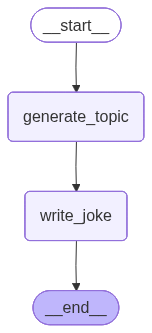

In [7]:
graph

## Running the Workflow

Execute the graph. It will pause at the interrupt and return state with `__interrupt__`.

In [8]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

state = graph.invoke({}, config)

In [12]:
print(state["topic"])

print(state["__interrupt__"])

Cactus
[Interrupt(value='Do you want to hear a joke about Cactus? (Y/N)', id='eb7433a42724fabdc666dbbb14f44738')]


In [13]:
from langgraph.types import Command

graph.invoke(Command(resume="Y"), config=config)

{'topic': 'Cactus',
 'joke': 'Why did the cactus get promoted? Because it always stuck to its goals.'}

## Time Travel: Viewing State History

Each execution step creates a checkpoint. Use `get_state_history()` to view all states.

In [14]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print("\n-----------------\n")

()
1f10953b-0e03-6ddc-8002-e8626f414058

-----------------

('write_joke',)
1f109537-9faa-6eb0-8001-a7ca5b41e7b7

-----------------

('generate_topic',)
1f109537-8ca0-6a18-8000-97cc8373dada

-----------------

('__start__',)
1f109537-8c9f-64f6-bfff-551afc8009cb

-----------------



In [15]:
for state in states:
    print(state)
    print("\n------------------")

StateSnapshot(values={'topic': 'Cactus', 'joke': 'Why did the cactus get promoted? Because it always stuck to its goals.'}, next=(), config={'configurable': {'thread_id': 'dce985ab-19fb-46ae-9044-b14ece18ab29', 'checkpoint_ns': '', 'checkpoint_id': '1f10953b-0e03-6ddc-8002-e8626f414058'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-02-14T03:17:27.961730+00:00', parent_config={'configurable': {'thread_id': 'dce985ab-19fb-46ae-9044-b14ece18ab29', 'checkpoint_ns': '', 'checkpoint_id': '1f109537-9faa-6eb0-8001-a7ca5b41e7b7'}}, tasks=(), interrupts=())

------------------
StateSnapshot(values={'topic': 'Cactus'}, next=('write_joke',), config={'configurable': {'thread_id': 'dce985ab-19fb-46ae-9044-b14ece18ab29', 'checkpoint_ns': '', 'checkpoint_id': '1f109537-9faa-6eb0-8001-a7ca5b41e7b7'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-14T03:15:55.860334+00:00', parent_config={'configurable': {'thread_id': 'dce985ab-19fb-46ae-9044-b14

In [16]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'Cactus'}


## Time Travel: Modifying Past State

Use `update_state()` to change a previous checkpoint and create a new branch from that point.

In [17]:
new_config = graph.update_state(selected_state.config, values={"topic": "parrots"})
print(new_config)

{'configurable': {'thread_id': 'dce985ab-19fb-46ae-9044-b14ece18ab29', 'checkpoint_ns': '', 'checkpoint_id': '1f10953c-d3dc-6fa8-8002-8bf59c4eaf0a'}}


In [18]:
state = graph.invoke(None, new_config)

In [19]:
print(state["__interrupt__"])

[Interrupt(value='Do you want to hear a joke about parrots? (Y/N)', id='9e63ca29b09db2a5b30388547ea10e03')]


In [20]:
graph.invoke(Command(resume="Y"), config=new_config)

{'topic': 'parrots',
 'joke': 'I told my parrot to stop repeating me. He said, "Stop repeating me."'}